In [193]:
## code was written using Python 2.7.13 ##
import os
import matplotlib.pyplot as plt  #v1.5.1
%matplotlib inline
import seaborn as sns #v0.7.1
import numpy as np #v1.14.4
import scipy.stats as stats #v0.19.0
from sklearn.decomposition import PCA
from os import listdir
import csv
import math
import pandas as pd #0.23.0
import sklearn #0.18.1
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [1]:
##EDIT THIS SECTION.

%cd 'C:\Users\Stuber Lab\Desktop\Raw data\obesity imaging\'

colors = ['g','darkorange']

## normalize data by baseline?
normalize_on=['yes']
baseline=[20,35]
test=[35,50]

## Save Figures?
save_figs=['no']

## Save files?
save_files=['no']

C:\Users\Stuber Lab\Desktop\Raw data\obesity imaging


In [167]:
def analyze_obesity(basedir1,basedir2,condition1,condition2,filename):
    condition=[condition1]+[condition2]
    maxnumneurons = 1000 #just used to initialize arrays. Should be larger than the total number of neurons
    maxframes=2000
    framerate=5
    maxtrials=10    #number of trials
    framespertrial=70
    numpreframes=35

    ## Load files in basedir1 and basedir2
    def load_files(directory):
        signals_pop = np.nan*np.zeros((maxtrials,framespertrial,maxnumneurons))
        data_dirs = os.walk(directory).next()[1]
        numneuronstillnow = 0
        for data_dir in data_dirs:
            signals=np.load(os.path.join(directory,data_dir,'lick_align.npy'))
            numneurons=signals.shape[2]
            numframes=signals.shape[1]
            numtrials=signals.shape[0]
            for a in range(0,numneurons):
                signals_pop[0:numtrials,0:signals.shape[1],numneuronstillnow+a]=signals[0:maxtrials,:,a]
            numneuronstillnow += numneurons
        extractedsignals=signals_pop[:,:,:numneuronstillnow]
        print 'files = '+str(data_dirs)
        print '\nNumber of neurons = '+str(extractedsignals.shape[2])
        return extractedsignals,numneuronstillnow,numframes,numneurons,numtrials
    extractedsignals1,numneuronstillnow1,numframes1,numneurons1,numtrials1=load_files(basedir1)
    extractedsignals2,numneuronstillnow2,numframes2,numneurons2,numtrials2=load_files(basedir2)

    #normalize data by baseline period
    if normalize_on[0]=='yes':
        def normalize_data(data):
            BLnorm=np.nan*np.zeros((data.shape))
            BLavg=np.nan*np.zeros((data.shape[0],data.shape[2]))
            for b in range(0,data.shape[2]):
                for a in range(0,data.shape[0]):
                    BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
            for e in range(0,data.shape[2]):
                for d in range(0,data.shape[1]):
                    for c in range(0,data.shape[0]):
                        BLnorm[c,d,e]=data[c,d,e]-BLavg[c,e]
            reshape_response=BLnorm
            return reshape_response
        extractedsignals1_norm=normalize_data(extractedsignals1)
        extractedsignals2_norm=normalize_data(extractedsignals2)
    else:
        extractedsignals1_norm=extractedsignals1
        extractedsignals2_norm=extractedsignals2

    avg_response1=np.nanmean(extractedsignals1_norm,axis=0)
    avg_response2=np.nanmean(extractedsignals2_norm,axis=0)
    peak_response1=np.nanmax(avg_response1[test[0]:test[1],:],axis=0)
    peak_response2=np.nanmax(avg_response2[test[0]:test[1],:],axis=0)
    avg_rew_response1=np.nanmean(avg_response1[test[0]:test[1],:],axis=0)
    avg_rew_response2=np.nanmean(avg_response2[test[0]:test[1],:],axis=0)
    #remove frames preceding start of baseline window
    avg_response1=avg_response1[baseline[0]:,:]
    avg_response2=avg_response2[baseline[0]:,:]
    framespertrial=framespertrial-baseline[0]
    if save_files[0]=='yes':
        np.savetxt(filename+'_avg_response_'+condition[0]+'.csv',avg_rew_response1.T,delimiter=',')
        np.savetxt(filename+'_avg_response_'+condition[1]+'.csv',avg_rew_response2.T,delimiter=',')

    ##combine arrays for bar plots
    def combine_arrays(data1,data2):
        max_events=[data1.shape[0],data2.shape[0]]
        max_events=np.max(max_events)
        combined_array=np.nan*np.zeros((max_events,2))
        combined_array[:data1.shape[0],0]=data1
        combined_array[:data2.shape[0],1]=data2
        return combined_array
    peak_amp_combined=combine_arrays(peak_response1,peak_response2)
    avg_response_combined=combine_arrays(avg_rew_response1,avg_rew_response2)

    def bar_plot(data,ytitle,ylim):
        data1=data[:,0];data1=data1[~np.isnan(data1)]
        data2=data[:,1];data2=data2[~np.isnan(data2)]
        means=np.nanmean(data[:,:],axis=0)
        sems=np.nan*np.zeros((1,2))
        sems[:,0]=stats.sem(data1,axis=0)
        sems[:,1]=stats.sem(data2,axis=0)
        sems=np.squeeze(sems)
        ind = (0,.5)
        width = 0.4
        fig_sig1,ax=plt.subplots(1,figsize=(3,6))
        bar=ax.bar(ind,means,width,yerr=sems,color=colors,error_kw={'ecolor':'black','linewidth':2})
        ax.set_ylabel(ytitle)
        ax.legend((bar[0],bar[1]),(condition[0],condition[1]),loc=[1,.5])
        ax.set_axis_bgcolor('white')
        ax.set_xticks([])
        ax.set_yticks([1,1.1,1.2])
        ax.set_ylim(ylim[0],ylim[1])
        if save_figs[0]=='yes':
            fig_sig1.savefig((filename+'_'+ytitle+'_AVG_bar'+'.png'), format='png',bbox_inches='tight')
        plt.show()
    fig3=bar_plot(avg_response_combined,'Avg amplitude',[0,.10])

    ymin=-.05
    ymax=.15
    sns.set(font_scale=1.5)
    fig1,ax = plt.subplots(1)
    sns.tsplot(avg_response1.T,color=colors[0], condition=condition[0]+' (n = '+str(extractedsignals1.shape[2])+')', legend=True)
    sns.tsplot(avg_response2.T,color=colors[1], condition=condition[1]+' (n = '+str(extractedsignals2.shape[2])+')', legend=True)
    ax.set_title('Avg response',fontsize='16')
    ax.set_xlabel('Time from lick (s)',fontsize='16')
    ax.set_ylabel('delta F',fontsize='16')
    ax.set_axis_bgcolor('white')
    # ax.set_yticks([1,1.1,1.2])
    ax.set_ylim(ymin,ymax)
    ax.set_xticks(range(5, framespertrial+1, 10))
    ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
    ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [ymin, ymax], '--k', linewidth=1)
    ax.plot([0, framespertrial], [1, 1], '--k', linewidth=1)
    if save_figs[0]=='yes':
        plt.savefig((filename+'_pop_response_overlay'+'.pdf'), format='pdf')
        plt.savefig((filename+'_pop_response_overlay'+'.png'), format='png')
        plt.show()

    #plot population heatmaps sorted
    sortneurons1 = np.argsort(np.nanmean(avg_response1[numpreframes-baseline[0]:(numpreframes-baseline[0])+(test[1]-test[0]),:],axis=0))
    sortneurons2 = np.argsort(np.nanmean(avg_response2[numpreframes-baseline[0]:(numpreframes-baseline[0])+(test[1]-test[0]),:],axis=0))
    fig4 = plt.figure(4)
    ax = plt.subplot(121)
    sns.heatmap(avg_response1[:,sortneurons1].T, cmap=plt.get_cmap('coolwarm'), vmin=-.2, vmax=.2,linewidth=0)
    ax.set_title(filename+' '+str(condition[0]), fontsize=16)
    ax.set_xlabel('Time from lick (s)', fontsize=14, labelpad=-1)
    ax.set_xticks(range(5, framespertrial+1, 10))
    ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
    ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [0, extractedsignals1.shape[2]], '--k', linewidth=1)
    ax.set_yticks(range(0, extractedsignals1.shape[2], 100))
    ax.set_yticklabels([str(a) for a in range(0,extractedsignals1.shape[2],100)],fontsize='14')
    plt.xticks(fontsize='14')
    plt.yticks(fontsize='14')
    plt.ylabel('ROIs', fontsize='16')
    fig4.tight_layout(w_pad=5)

    fig5 = plt.figure(4)
    ax = plt.subplot(122)
    sns.heatmap(avg_response2[:,sortneurons2].T, cmap=plt.get_cmap('coolwarm'), vmin=-.2, vmax=.2,linewidth=0)
    ax.set_title(filename+' '+str(condition[1]), fontsize=16)
    ax.set_xlabel('Time from lick (s)', fontsize=14, labelpad=-1)
    ax.set_xticks(range(5, framespertrial+1, 10))
    ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
    ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [0, extractedsignals2.shape[2]], '--k', linewidth=1)
    ax.set_yticks(range(0, extractedsignals1.shape[2], 100))
    ax.set_yticklabels([str(a) for a in range(0,extractedsignals2.shape[2],100)],fontsize='14')
    plt.xticks(fontsize='14')
    plt.yticks(fontsize='14')
    plt.ylabel('ROIs', fontsize='16')
    fig5.tight_layout(w_pad=5)
    if save_figs[0]=='yes':
        plt.savefig(filename+'_heatmap_sorted.pdf', format='pdf')
        plt.show()
    return avg_rew_response1,avg_rew_response2,peak_response1,peak_response2

files = ['B5 011616 hungry', 'B5 030916 hungry', 'G1 071416 615um hungry', 'G10 090816 700um hungry', 'G3 071416 670um hungry', 'G7 071216 495um hungry', 'G9 090616 640um hungry']

Number of neurons = 232
files = ['B4 0000 hungry', 'B4 030916 hungry', 'B6 031616', 'G11 090816 680um hungry', 'G4 071416 550um hungry', 'G5 071216 720um hungry', 'G6 071216 720um hungry', 'G8 090616 690um hungry']

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: Mean of empty slice
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:89: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.




Number of neurons = 220


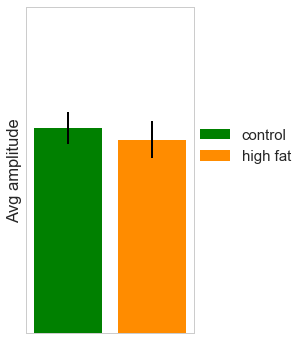

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:107: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


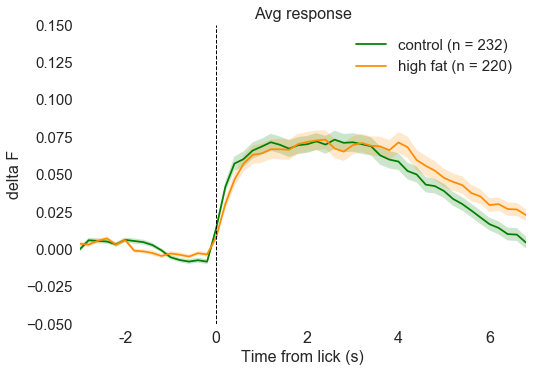

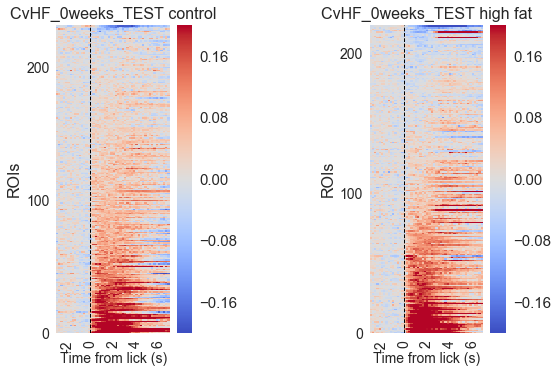

In [168]:
## plot data for 0 week condition ##
basedir1 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\10suc\\Pre\\control-pre'
basedir2 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\10suc\\Pre\\high fat-pre'
condition1='control'
condition2='high fat'
filename='CvHF_0weeks_TEST'
C_0wk_avg,HF_0wk_avg,C_0wk_peak,HF_0wk_peak=analyze_obesity(basedir1=basedir1,basedir2=basedir2,condition1=condition1,condition2=condition2,filename=filename)

files = ['B5 033016 680um hungry', 'G1 081616 615um hungry', 'G10 092316 700um hungry', 'G3 081616 675um hungry', 'G7 081816 495um hungry', 'G9 092116 640um hungry']

Number of neurons = 188
files = ['B4 033016 750um hungry', 'B6 033116 625um hungry', 'G11 092316 680um hungry', 'G4 081616 550um hungry', 'G5 081816 720um hungry', 'G6 081816 720um hungry', 'G8 092116 690um hungry']

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: Mean of empty slice
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:89: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.




Number of neurons = 231


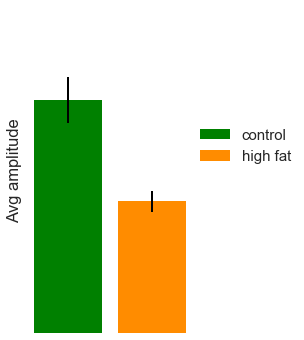

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:107: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


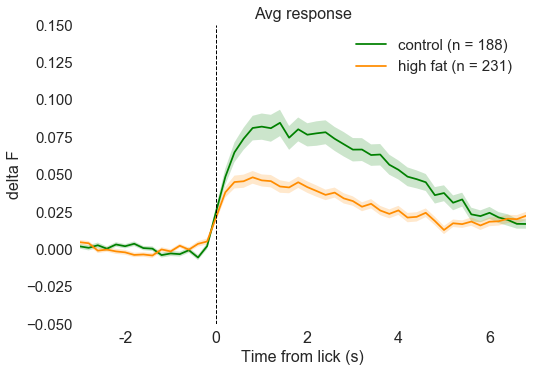

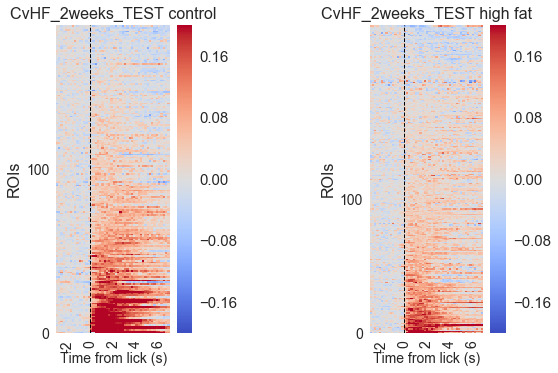

In [172]:
## plot data for 2 week condition ##
basedir1 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\10suc\\2wks\\control 2wks'
basedir2 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\10suc\\2wks\\HF 2wks'
condition1='control'
condition2='high fat'
filename='CvHF_2weeks_TEST'
C_2wk_avg,HF_2wk_avg,C_2wk_peak,HF_2wk_peak=analyze_obesity(basedir1=basedir1,basedir2=basedir2,condition1=condition1,condition2=condition2,filename=filename)

files = ['B5 060816 680um hungry', 'G1 102616 615um hungry', 'G10 113016 700um hungry', 'G3 102616 720um hungry']

Number of neurons = 105
files = ['B4 060816 780um hungry', 'B6 060916 630um hungry', 'G11 113016 680um hungry', 'G4 102616 550um hungry', 'G5 102816 720um hungry', 'G6 102816 720um hungry', 'G8 113016 690um hungry']

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: Mean of empty slice
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:89: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.




Number of neurons = 201


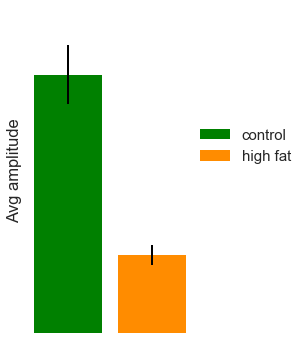

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:107: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


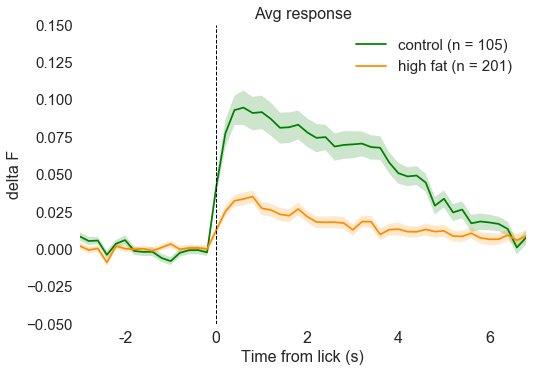

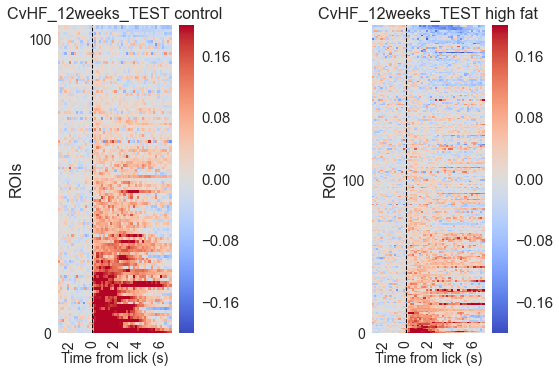

In [173]:
## plot data for 0 week condition ##
basedir1 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\10suc\\12wks\\control 12wks'
basedir2 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry all neurons\\10suc\\12wks\\HF 12wks'
condition1='control'
condition2='high fat'
filename='CvHF_12weeks_TEST'
C_12wk_avg,HF_12wk_avg,C_12wk_peak,HF_12wk_peak=analyze_obesity(basedir1=basedir1,basedir2=basedir2,condition1=condition1,condition2=condition2,filename=filename)

(452, 4)
('prediction accuracy = ', 0.59188544152744627)
('shuffled accuracy = ', 0.54892601431980914)
0
('prediction accuracy = ', 0.58722358722358725)
('shuffled accuracy = ', 0.51842751842751844)
1
('prediction accuracy = ', 0.60532687651331718)
('shuffled accuracy = ', 0.58111380145278446)
2
('prediction accuracy = ', 0.6034063260340633)
('shuffled accuracy = ', 0.51581508515815089)
3
('prediction accuracy = ', 0.61084905660377353)
('shuffled accuracy = ', 0.55424528301886788)
4
('prediction accuracy = ', 0.58851674641148322)
('shuffled accuracy = ', 0.53349282296650713)
5
('prediction accuracy = ', 0.60442260442260443)
('shuffled accuracy = ', 0.55773955773955775)
6
('prediction accuracy = ', 0.59649122807017541)
('shuffled accuracy = ', 0.53634085213032578)
7
('prediction accuracy = ', 0.58585858585858586)
('shuffled accuracy = ', 0.58333333333333337)
8
('prediction accuracy = ', 0.60774818401937047)
('shuffled accuracy = ', 0.56658595641646492)
9
('prediction accuracy = ', 0.603

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


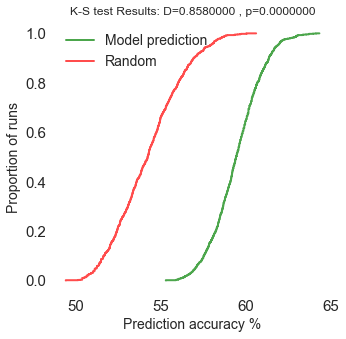

59.4499104428
54.2582552277


In [209]:
##Use SVM to classify data based on 'group' (Fig. 2f) ##

## create dataframes for SVM ##
##group1=high fat; group0=control
def create_df(avg,peak,group,timepoint):
    df=pd.DataFrame()
    df['avg']=avg
    df['peak']=peak
    df['group']=group
    df['timepoint']=timepoint
    return df
df_C0H=create_df(C_0wk_avg,C_0wk_peak,0,0)
df_HF0H=create_df(HF_0wk_avg,HF_0wk_peak,1,0)
df_C2H=create_df(C_2wk_avg,C_2wk_peak,0,2)
df_HF2H=create_df(HF_2wk_avg,HF_2wk_peak,1,2)
df_C12H=create_df(C_12wk_avg,C_12wk_peak,0,12)
df_HF12H=create_df(HF_12wk_avg,HF_12wk_peak,1,12)
frames = [df_HF0H,df_HF2H,df_C2H,df_C12H,df_HF12H]
df=pd.concat(frames)
df=df_C0H.append(frames,ignore_index=True)
df=df.dropna(axis=0)
dfreduced=df.dropna(axis=0)
df_norm=dfreduced

### EDIT THIS to restrict timepoint  ###
timepoint=0 ## either 0, 2, or 12 
df_norm=df_norm[(df_norm['timepoint']==timepoint)]
predict_outcome='group'  #which parameter do you want to predict (values should be 0 or 1)
print df_norm.shape
svm_filename='Sucrose_0wks_pred_group'
iterations=1000 #Define number of iterations
test_data=.1  #defines split for test/train sets
test=[35,50]
### End Edit ###

df=df_norm
parameters = [{'C': [0.001, .01,.1,1,10,100,1000], 'kernel': ['linear']},
              {'C': [0.001, .01,.1,1,10,100,1000], 'gamma': [0.001, .01,.1,1,10,100,1000], 'kernel': ['rbf']}]
pred_score=np.nan*np.zeros((iterations))
rand_score=np.nan*np.zeros((iterations))
for i in range(iterations):
    ##randomly subset df into test and train sets
    msk = np.random.rand(len(df))>test_data
    train = df[msk]
    clf = GridSearchCV(SVC(), parameters,cv=10)
    train_labels=train[[predict_outcome]].values
    c,r=train_labels.shape
    train_labels=train_labels.reshape(c,)
    clf.fit(train[['avg','peak']], train_labels)
    print ('prediction accuracy = ', clf.best_score_)
    pred_score[i]=(clf.best_score_)*100
    ##random array of 1s and 0s for shuffled classifier
    rand_group=pd.DataFrame(np.random.randint(2,size=train.shape[0]))
    clf.fit(train[['avg','peak']], rand_group[0])
    print ('shuffled accuracy = ', clf.best_score_)
    rand_score[i]=(clf.best_score_)*100
    print i

d,p=stats.ks_2samp(pred_score,rand_score)
plt.figure(figsize=(5,5))
ax=plt.subplot(111)
n = np.arange(1,len(pred_score)+1) / np.float(len(pred_score))
Xs = np.sort(pred_score)
plt.step(Xs,n,color='g',label='Model prediction',alpha=0.7,linewidth=2)
n2= np.arange(1,len(rand_score)+1) / np.float(len(rand_score))
Xs2= np.sort(rand_score)
plt.step(Xs2,n,color='r',label='Random',alpha=0.7,linewidth=2)

ax.set_axis_bgcolor('white')
plt.xlabel('Prediction accuracy %',fontsize=14)
plt.ylabel('Proportion of runs',fontsize=14)
plt.title('K-S test Results: '+str("D={0:.7f}".format(round(d,3)))+' , '+str("p={0:.7f}".format(round(p,3))),fontsize=12)
plt.legend(fontsize=14,loc=2)
plt.savefig(str(iterations)+str('iter_')+str(test_data)+str(timepoint)+'wks_test_data_prediction_accuracy_hist.pdf')
np.savetxt(svm_filename+str(iterations)+'iterations_'+str(test_data)+'_'+str(timepoint)+'wks_split_prediction_accuracy.csv',pred_score,delimiter=',')
np.savetxt(svm_filename+str(iterations)+'iterations_'+str(test_data)+'_'+str(timepoint)+'wks_split_RANDOM_prediction_accuracy.csv',rand_score,delimiter=',')
plt.show()

print np.nanmean(pred_score)
print np.nanmean(rand_score)

files = ['B5 030916 hungry', 'G1 071416 615um hungry', 'G10 090816 700um hungry', 'G3 071416 670um hungry']

Number of neurons = 44
files = ['B4 011116 hungry', 'B6 031616 600um hungry', 'G5 071216 720um hungry', 'G6 071216 720um hungry']

Number of neurons = 33


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:89: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


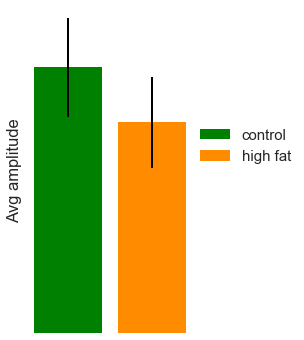

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:107: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


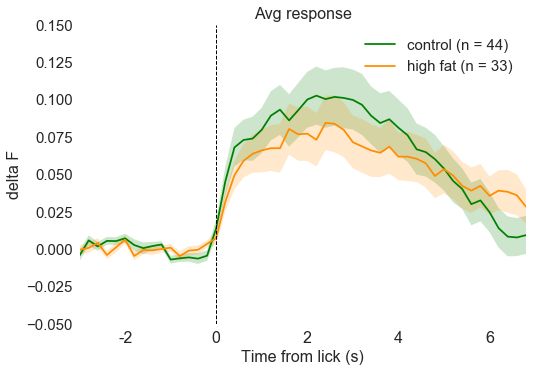

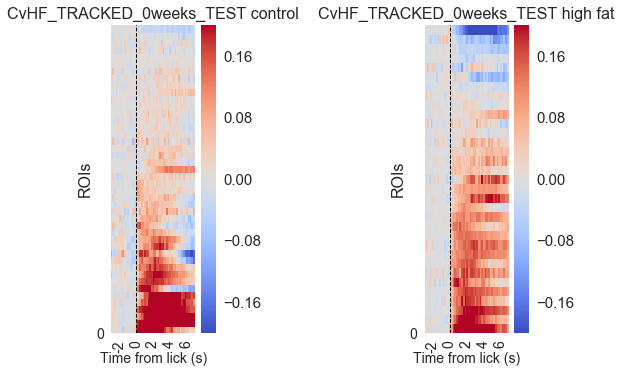

In [59]:
## plot data for 0 week condition TRACKED CELLS##
basedir1 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\sucrose responses\\Pre\\control-pre'
basedir2 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\sucrose responses\\Pre\\high fat-pre'
condition1='control'
condition2='high fat'
filename='CvHF_TRACKED_0weeks_TEST'
C_0wk_tracked,HF_0wk_tracked=analyze_obesity(basedir1=basedir1,basedir2=basedir2,condition1=condition1,condition2=condition2,filename=filename)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: Mean of empty slice
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:89: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


files = ['B5 033016 680um hungry', 'G1 081616 615um hungry', 'G10 092316 700um hungry', 'G3 081616 675um hungry']

Number of neurons = 44
files = ['B4 033016 750um hungry', 'B6 033116 625um hungry', 'G5 081816 720um hungry', 'G6 081816 720um hungry']

Number of neurons = 33


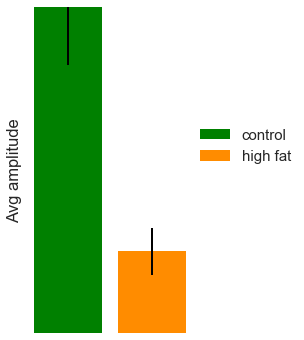

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:107: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


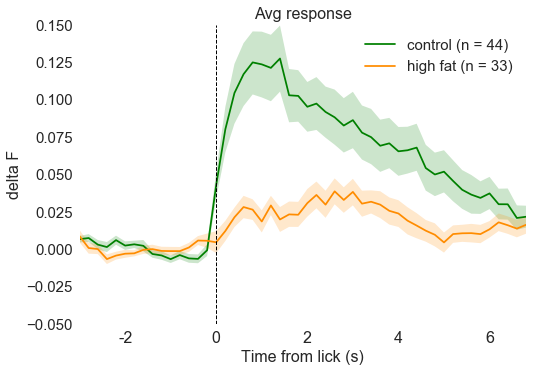

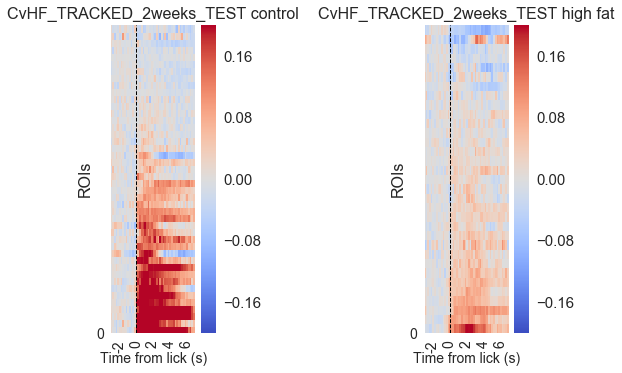

In [60]:
## plot data for 2 week condition TRACKED CELLS##
basedir1 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\sucrose responses\\2wks\\control 2wks'
basedir2 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\sucrose responses\\2wks\\HF 2wks'
condition1='control'
condition2='high fat'
filename='CvHF_TRACKED_2weeks_TEST'
C_2wk_tracked,HF_2wk_tracked=analyze_obesity(basedir1=basedir1,basedir2=basedir2,condition1=condition1,condition2=condition2,filename=filename)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: Mean of empty slice
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:89: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


files = ['B5 060816 680um hungry', 'G1 102616 615um hungry', 'G10 113016 700um hungry', 'G3 102616 720um hungry']

Number of neurons = 44
files = ['B4 060816 780um hungry', 'B6 060916 630um hungry', 'G5 102816 720um hungry', 'G6 102816 720um hungry']

Number of neurons = 33


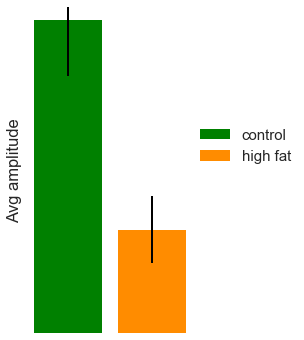

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:107: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


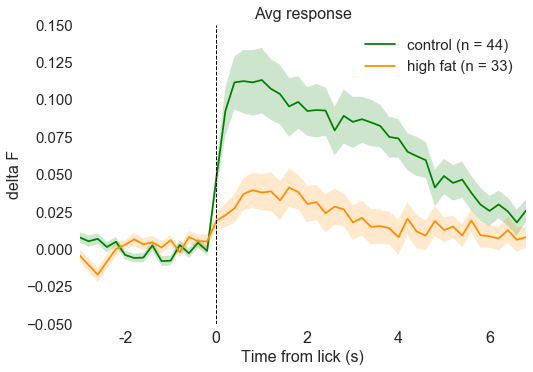

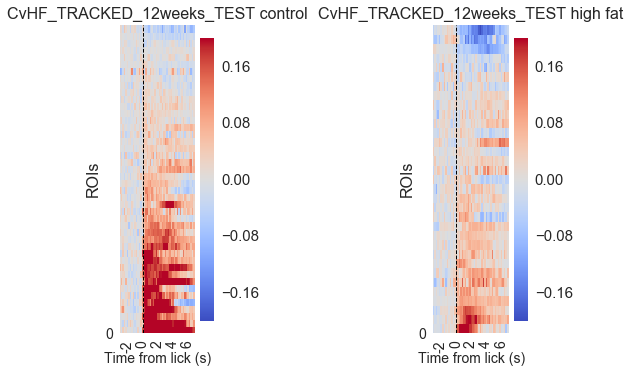

In [61]:
## plot data for 2 week condition TRACKED CELLS##
basedir1 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\sucrose responses\\12wks\\control 12wks'
basedir2 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\obesity imaging\\hungry tracked\\sucrose responses\\12wks\\HF 12wks'
condition1='control'
condition2='high fat'
filename='CvHF_TRACKED_12weeks_TEST'
C_12wk_tracked,HF_12wk_tracked=analyze_obesity(basedir1=basedir1,basedir2=basedir2,condition1=condition1,condition2=condition2,filename=filename)

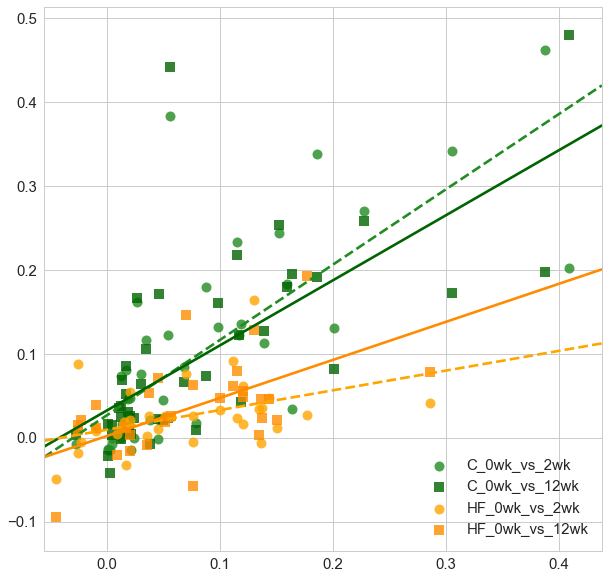

In [98]:
## compare tracked cells (Fig. 2h) ##
sns.set_style('whitegrid')
fig10 = plt.figure(figsize=(10,10))
ax=sns.regplot(C_0wk_tracked,C_2wk_tracked,scatter=True,color='forestgreen',ci=None, scatter_kws={'s':100},line_kws={'linestyle':'dashed'},label='C_0wk_vs_2wk')
ax=sns.regplot(C_0wk_tracked,C_12wk_tracked,scatter=True,color='darkgreen',ci=None,marker='s', scatter_kws={'s':100},label='C_0wk_vs_12wk')
ax=sns.regplot(HF_0wk_tracked,HF_2wk_tracked,scatter=True,color='orange',ci=None, scatter_kws={'s':100},line_kws={'linestyle':'dashed'},label='HF_0wk_vs_2wk')
ax=sns.regplot(HF_0wk_tracked,HF_12wk_tracked,scatter=True,color='darkorange',ci=None,marker='s', scatter_kws={'s':100},label='HF_0wk_vs_12wk')
ax.legend(loc='best')
plt.show()

In [126]:
## normalize sucrose responses by 0 week condition and plot bars (Fig. S3g) ##
C_0wk_tracked_norm=(C_0wk_tracked/float(np.nanmean(C_0wk_tracked)))*100
C_2wk_tracked_norm=(C_2wk_tracked/float(np.nanmean(C_0wk_tracked)))*100
C_12wk_tracked_norm=(C_12wk_tracked/float(np.nanmean(C_0wk_tracked)))*100
HF_0wk_tracked_norm=(HF_0wk_tracked/float(np.nanmean(HF_0wk_tracked)))*100
HF_2wk_tracked_norm=(HF_2wk_tracked/float(np.nanmean(HF_0wk_tracked)))*100
HF_12wk_tracked_norm=(HF_12wk_tracked/float(np.nanmean(HF_0wk_tracked)))*100

## manually calculate means and sems to go into bar plot ##
means=np.nan*np.zeros((2,3))
sem=np.nan*np.zeros((2,3))
sem[0,0]=stats.sem(C_0wk_tracked_norm,ddof=0)
sem[0,1]=stats.sem(C_2wk_tracked_norm,ddof=0)
sem[0,2]=stats.sem(C_12wk_tracked_norm,ddof=0)
sem[1,0]=stats.sem(HF_0wk_tracked_norm,ddof=0)
sem[1,1]=stats.sem(HF_2wk_tracked_norm,ddof=0)
sem[1,2]=stats.sem(HF_12wk_tracked_norm,ddof=0)
means[0,0]= C_0wk_tracked_norm.mean()
means[0,1]= C_2wk_tracked_norm.mean()
means[0,2]= C_12wk_tracked_norm.mean()
means[1,0]= HF_0wk_tracked_norm.mean()
means[1,1]= HF_2wk_tracked_norm.mean()
means[1,2]= HF_12wk_tracked_norm.mean()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


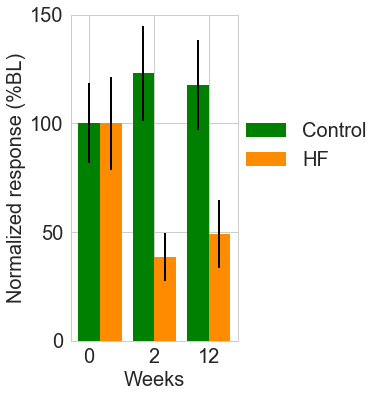

In [165]:
## plot bars for Fig. S8g ##
ind = (0,1,2)
ind2=(0.4,1.4,2.4)
width = 0.4
ylim=[0,150]
fig_tracked_bars,ax=plt.subplots(1,figsize=(3,6))
plt.bar=ax.bar(ind,means[0,:],width,yerr=sem[0,:],color='g',error_kw={'ecolor':'black','linewidth':2})
plt.bar1=ax.bar(ind2,means[1,:],width,yerr=sem[1,:],color='darkorange',error_kw={'ecolor':'black','linewidth':2})
ax.legend((bar[0],bar1[1]),(condition[0],condition[1]),loc=[1,.5],fontsize=20)
ax.set_axis_bgcolor('white')
plt.xticks((0,1.2,2.2),(0,2,12),fontsize=20)
plt.xlabel('Weeks',fontsize=20)
plt.ylabel('Normalized response (%BL)',fontsize=20)
plt.yticks((0,50,100,150),fontsize=20)
ax.set_ylim(ylim[0],ylim[1])
if save_figs[0]=='yes':
    fig_tracked_bars.savefig((filename+'_TRACKED_amplitude_AVG_bar.png'), format='png',bbox_inches='tight')
plt.show()